# Demo of SF error analysis
### Semi-empirical approach to computing second-order statistics of gapped series

Statistical moments of increments. 
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

**Outputs (plots):**
1. Bad and interpolated SF example
2. CH estimator example
3. Bad and LINT: MPE as fn of lag, coloured by % missing overall (multi-line plot)
3. Bad and LINT: Heatmaps of MPE as fn of lag and % missing
4. LINT: Empirically-corrected SFs
5. LINT: Hybrid correction

**Next steps: (commit as you go)**

2. Add C-H estimator
3. Add this to final plot of corrections at the end (as well as an initial correction)
4. Work on inputs: more, standardised lengths
5. Confirm Rāpoi params
6. Convert to Rāpoi script
7. Run on Rāpoi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sf_funcs import (
    compute_sf,
    plot_sample,
    plot_error_trend_line,
    plot_error_trend_scatter,
    plot_heatmap,
    compute_scaling,
)
import ts_dashboard_utils as ts

plt.rcParams.update({"font.size": 10})

## Load in the data
A magnetic field time series from PSP

In [2]:
df = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")

# Split df into 10 subsets of length 1000
good_inputs_list = np.array_split(df[:25000]["B_R"], 5)

del df  # free up memory

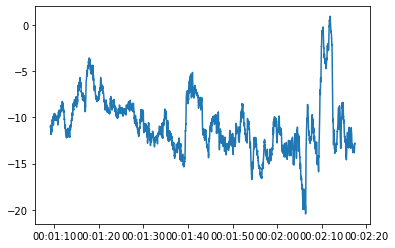

In [3]:
plt.plot(good_inputs_list[0])

Optionally, check the data for missing data and its frequency, get summary stats

In [4]:
### 0PTIONAL CODE ###
check = good_inputs_list[4]

if check.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{check.isnull().sum()} missing points")
print("Length of interval: " + str(check.notnull().sum()))
print("Duration of interval: " + str(check.index[-1] - check.index[0]))
x = check.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(check.index[2] - check.index[1])
print(check.index[3] - check.index[2])
print(check.index[4] - check.index[3])

a = check.index[2] - check.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 5000
Duration of interval: 0 days 00:01:08.252977920
Duration between some adjacent data points:
0 days 00:00:00.013653248
0 days 00:00:00.013653504
0 days 00:00:00.013653376

Frequency is 73.24 Hz (2dp)
Mean = -31.76543921699524
Standard deviation = 3.313050337032281


## Remove data from each input multiple times and compute SF, naive and interpolated

**Run this on Rāpoi:** currently it takes ~0.5s per 1000 length interval (up to lag 250)

In [5]:
# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(good_inputs_list[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(good_inputs_list[0]))
powers = [2]
times_to_gap = 10

good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

for i, input in enumerate(good_inputs_list):
    print("\nProcessing input {}".format(i))
    good_output = compute_sf(pd.DataFrame(input), lags, powers)
    good_outputs_list.append(good_output)

    bad_inputs_list = []
    bad_outputs_list = []
    interp_inputs_list = []
    interp_outputs_list = []

    for total_removal in np.random.uniform(0, 0.9, times_to_gap):
        # Remove data (up to about 90%, may be some numerical issues with large %)
        # in both chunks and uniformly - split given by ratio_removal
        ratio_removal = np.random.uniform()
        print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=5
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )

        print(
            "Removed {0:.1f}% (approx. {1:.1f}% in chunks, {2:.1f}% uniformly)".format(
                prop_removed * 100, prop_remove_chunks * 100, prop_remove_unif * 100
            )
        )

        bad_inputs_list.append(bad_input)

        # Linearly interpolate the missing data
        interp_input = bad_input.interpolate(method="linear")
        interp_inputs_list.append(interp_input)

        bad_output = compute_sf(pd.DataFrame(bad_input), lags, powers)
        bad_output["error"] = bad_output["sosf"] - good_output["sosf"]
        bad_output["error_percent"] = bad_output["error"] / good_output["sosf"] * 100
        bad_output["missing_prop_overall"] = prop_removed
        bad_output["lint"] = False
        bad_outputs_list.append(bad_output)

        interp_output = compute_sf(pd.DataFrame(interp_input), lags, powers)
        interp_output["error"] = interp_output["sosf"] - good_output["sosf"]
        interp_output["error_percent"] = (
            interp_output["error"] / good_output["sosf"] * 100
        )
        interp_output["missing_prop_overall"] = prop_removed
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["sosf_se"] = bad_output["sosf_se"]
        # NOTE: Seems sensible uncertainty is the same for both
        interp_output["lint"] = True
        interp_outputs_list.append(interp_output)

    all_bad_inputs_list.append(bad_inputs_list)
    all_bad_outputs_list.append(bad_outputs_list)
    all_interp_inputs_list.append(interp_inputs_list)
    all_interp_outputs_list.append(interp_outputs_list)

Processing input 0


Nominal total removal: 78.0%
Nominal ratio: 32.4%
Removed 65.7% (approx. 25.2% in chunks, 52.7% uniformly)
Nominal total removal: 22.5%
Nominal ratio: 40.1%
Removed 21.8% (approx. 9.0% in chunks, 13.5% uniformly)
Nominal total removal: 73.6%
Nominal ratio: 20.8%
Removed 65.0% (approx. 15.3% in chunks, 58.3% uniformly)
Nominal total removal: 29.3%
Nominal ratio: 31.3%
Removed 27.4% (approx. 9.2% in chunks, 20.2% uniformly)
Nominal total removal: 41.0%
Nominal ratio: 14.0%
Removed 39.2% (approx. 5.7% in chunks, 35.2% uniformly)
Nominal total removal: 6.3%
Nominal ratio: 86.0%
Removed 7.3% (approx. 5.4% in chunks, 0.9% uniformly)
Nominal total removal: 34.4%
Nominal ratio: 7.7%
Removed 33.5% (approx. 2.6% in chunks, 31.7% uniformly)
Nominal total removal: 68.8%
Nominal ratio: 8.4%
Removed 65.5% (approx. 5.8% in chunks, 63.0% uniformly)
Nominal total removal: 74.3%
Nominal ratio: 87.9%
Removed 75.1% (approx. 65.3% in chunks, 9.0% uniformly)
Nominal total removal: 72.2%
Nominal ratio: 72.7%

## Check a sample of results, for a given source interval

### Naive

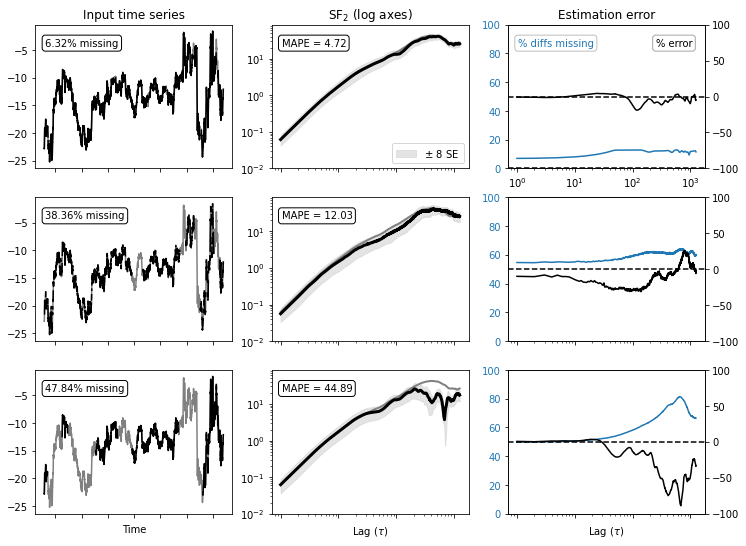

In [15]:
# Check results, for a given clean input

input_ind = 2
n = 3

plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    "C0",
    input_ind,
    n,
    False,
)

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, relecting the increased uncertainty of fewer *true* observations

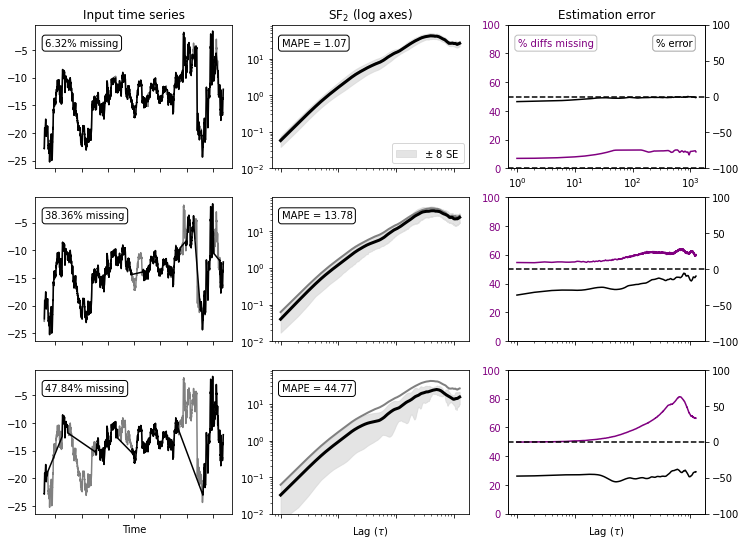

In [16]:
plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    "purple",
    input_ind,
    n,
    False,
)

## Do holistic analysis of errors

In [17]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis

bad_outputs_df = pd.concat([pd.concat(lst) for lst in all_bad_outputs_list])
interp_outputs_df = pd.concat([pd.concat(lst) for lst in all_interp_outputs_list])

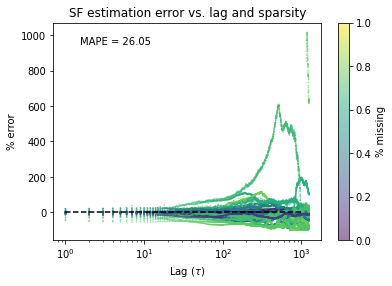

In [18]:
# View trends as fn of OVERALL missing amount
plot_error_trend_line(bad_outputs_df)

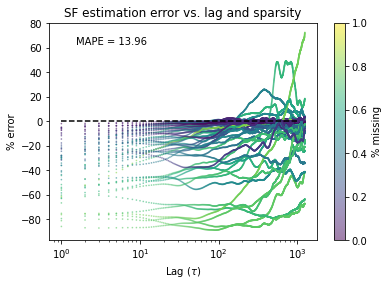

In [19]:
plot_error_trend_line(interp_outputs_df)

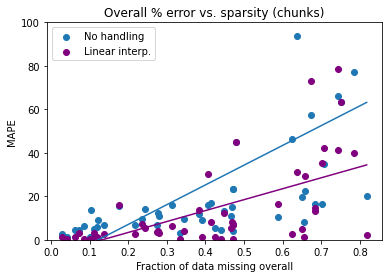

In [20]:
plot_error_trend_scatter(bad_outputs_df, interp_outputs_df)

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

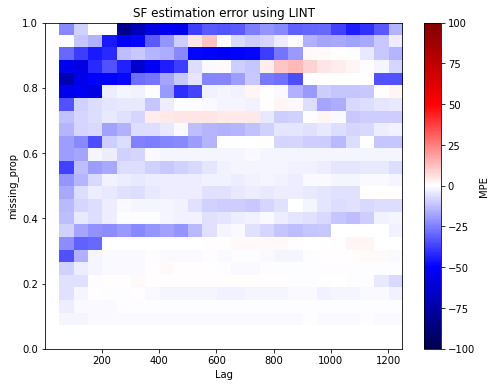

In [21]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
interp_heatmap = plot_heatmap(interp_outputs_df, "missing_prop")

In [24]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)
interval = 0
sf_corrected = compute_scaling(
    all_interp_outputs_list[input_ind][interval], "missing_prop", interp_heatmap
)

No nearest row found for lag 576.0! Scaling set to 1
No nearest row found for lag 577.0! Scaling set to 1
No nearest row found for lag 578.0! Scaling set to 1
No nearest row found for lag 579.0! Scaling set to 1
No nearest row found for lag 580.0! Scaling set to 1
No nearest row found for lag 581.0! Scaling set to 1
No nearest row found for lag 582.0! Scaling set to 1
No nearest row found for lag 583.0! Scaling set to 1
No nearest row found for lag 584.0! Scaling set to 1
No nearest row found for lag 585.0! Scaling set to 1
No nearest row found for lag 586.0! Scaling set to 1
No nearest row found for lag 587.0! Scaling set to 1
No nearest row found for lag 588.0! Scaling set to 1
No nearest row found for lag 589.0! Scaling set to 1
No nearest row found for lag 590.0! Scaling set to 1
No nearest row found for lag 591.0! Scaling set to 1
No nearest row found for lag 592.0! Scaling set to 1
No nearest row found for lag 593.0! Scaling set to 1
No nearest row found for lag 594.0! Scaling se

## Apply empirical correction factor

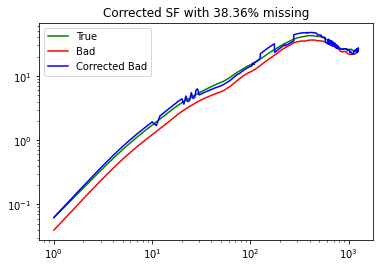

In [25]:
# Plot the corrected SF
plt.plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
plt.plot(all_interp_outputs_list[input_ind][interval]["sosf"], c="red", label="Bad")
plt.plot(
    sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.title(
    f"Corrected SF with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}% missing"
)
plt.show()